In [1]:
import gc
import math
import sys
sys.path.append("../../pytorch-forecasting")
sys.path.append('../')

import pytorch_lightning as pl
import seaborn as sns
import torch
from data_factory.dataLoader import StockPricesLoader
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import notebook
import numpy as np

from utilities import *
import pandas as pd
from tqdm.notebook import tqdm

from data_factory.prepared_data import TimeSeriesData, PreparedData
import math
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

sns.set_style("whitegrid")
tqdm.pandas()

import matplotlib.pyplot as plt

pl.seed_everything(42)

Global seed set to 42


42

In [2]:
config = load_config("../config/config.yml")
assert config['model'] == 'temporal_fusion_transformer', 'Invalid model in file configuration for this script'
model = config['model']
model_config = config[model]

data_ts: TimeSeriesData = TimeSeriesData.from_file('../data/save/timeseries_data.pkl')
data: PreparedData = PreparedData.from_file('../data/save/augmented_data.pkl')

max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']

#### load model

In [3]:
trainer = pl.Trainer(accelerator='gpu', max_epochs=-1)

model = TemporalFusionTransformer.load_from_checkpoint('./lightning_logs/version_6/checkpoints/epoch=7-step=237984.ckpt')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


#### Recreate dataloaders

In [4]:
# Training
train_dl = data_ts.train.to_dataloader(train=True, batch_size=batch_size, num_workers=12)


# Validation
val_dl = data_ts.val.to_dataloader(train=False, batch_size=batch_size, num_workers=12, shuffle=False)


# Testing
test_dl = data_ts.test.to_dataloader(
    batch_size=data_ts.test_set_size,
    num_workers=12,
    shuffle=False
)

#### Results

In [5]:
# Test set
y_true_test = torch.cat([y for _, (y, _) in tqdm(iter(test_dl))])
y_hat_test = trainer.predict(model, (X for X, (y, _) in test_dl))

y_hat_np_test = np.array([i.prediction.numpy() for i in y_hat_test]).reshape(-1, max_prediction_length, model_config['output_size'])
y_true_np_test = y_true_test.cpu().detach().numpy()

del y_hat_test, y_true_test
y_hat_np_test.shape, y_true_np_test.shape

  0%|          | 0/2000 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


((112000, 5, 7), (112000, 5))

In [6]:
# Val set
y_true_val = torch.cat([y for _, (y, _) in tqdm(iter(val_dl))])
y_hat_val = trainer.predict(model, (X for X, (y, _) in val_dl))
y_sc_val = torch.cat([X['encoder_cat'][:, 0, 0] for X, (_, _) in tqdm(iter(val_dl))])

y_hat_np_val = np.concatenate([i.prediction.numpy() for i in y_hat_val]).reshape(-1, max_prediction_length, model_config['output_size'])
y_true_np_val = y_true_val.cpu().detach().numpy()
del y_true_val, y_hat_val
y_hat_np_val.shape, y_true_np_val.shape

  0%|          | 0/1695 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1695 [00:00<?, ?it/s]

((108421, 5, 7), (108421, 5))

#### Rescale

In [7]:
# test
y_true_test_unscaled = y_true_np_test.reshape(data.test.SecuritiesCode.unique().size, -1, max_prediction_length).copy()
y_test_hat_unscaled = y_hat_np_test.reshape(data.test.SecuritiesCode.unique().size, -1, max_prediction_length * model_config['output_size']).copy()
# val
y_true_val_unscaled = y_true_np_val.copy()
y_val_hat_unscaled = y_hat_np_val.copy()


for i, scaler in tqdm(enumerate(data.scalers['Close'])):
    # test
    y_true_test_unscaled[i] = scaler.inverse_transform(y_true_test_unscaled[i])
    y_test_hat_unscaled[i] = scaler.inverse_transform(y_test_hat_unscaled[i])
    # val
    f = (y_sc_val == i)
    shape = y_val_hat_unscaled[f].shape
    y_true_val_unscaled[f] = scaler.inverse_transform(y_true_val_unscaled[f])
    y_val_hat_unscaled[f] = scaler.inverse_transform(y_val_hat_unscaled[f].reshape(shape[0], shape[1] * shape[2])).reshape(shape)

y_true_test_unscaled = y_true_test_unscaled.reshape(-1, config['temporal_fusion_transformer']['sliding_window']['max_prediction_length'])
y_test_hat_unscaled = y_test_hat_unscaled.reshape(-1, config['temporal_fusion_transformer']['sliding_window']['max_prediction_length'], model_config['output_size'])

0it [00:00, ?it/s]

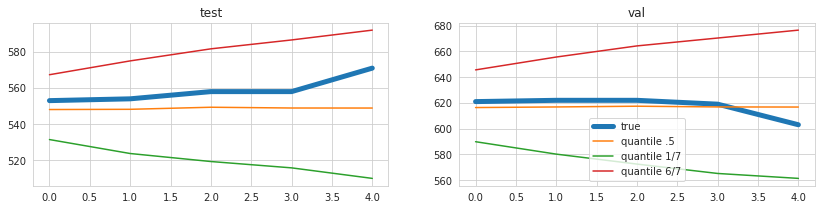

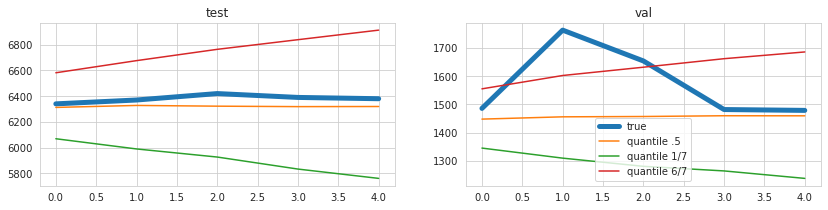

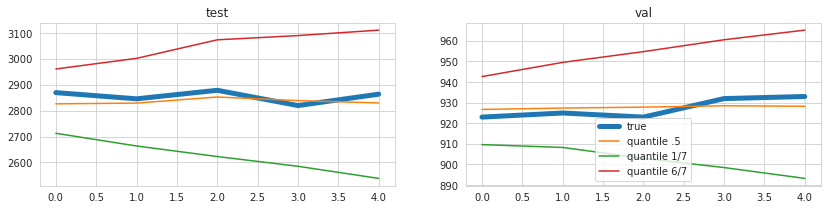

In [8]:
for id in range(100, 2000, 800):
    fig, axs = plt.subplots(1, 2, figsize=(14, 3))

    axs[0].plot(y_true_test_unscaled[id], linewidth=5, label='true')
    axs[0].plot(y_test_hat_unscaled[id, :, 3], label='quantile .5')
    axs[0].plot(y_test_hat_unscaled[id, :, 0], label='quantile 1/7')
    axs[0].plot(y_test_hat_unscaled[id, :, 6], label='quantile 6/7')
    axs[0].set_title('test')

    axs[1].plot(y_true_val_unscaled[id], linewidth=5, label='true')
    axs[1].plot(y_val_hat_unscaled[id, :, 3], label='quantile .5')
    axs[1].plot(y_val_hat_unscaled[id, :, 0], label='quantile 1/7')
    axs[1].plot(y_val_hat_unscaled[id, :, 6], label='quantile 6/7')
    axs[1].set_title('val')

    plt.legend()
    plt.show()

In [9]:
# test set
mid_value = math.floor(model_config['output_size'] / 2)

vt = (data.test.is_testing == True)

data.test.loc[vt, 'close_true'] = y_true_np_test[:, 0].flatten()
data.test.loc[vt, 'close_pred'] = y_hat_np_test[:, 0, mid_value].flatten()

data.test.loc[vt, 'close_true_unscaled'] = y_true_test_unscaled[:, 0].flatten()
data.test.loc[vt, 'close_pred_unscaled'] = y_test_hat_unscaled[:, 0, mid_value].flatten()

data.test.loc[vt, 'target_true'] = (y_true_np_test[:, 1] - y_true_np_test[:, 0]) / y_true_np_test[:, 0]
data.test.loc[vt, 'target_pred'] = (y_hat_np_test[:, 1, mid_value] - y_hat_np_test[:, 0, mid_value]) / y_hat_np_test[:, 0, mid_value]

for i in range(model_config['output_size']):
    data.test.loc[vt, f'close_pred_unscaled_full_{i}'] = pd.Series(list(y_test_hat_unscaled[:, :, i]), index=data.test[vt].index)

data.test.loc[vt, 'target_true_unscaled'] = (y_true_test_unscaled[:, 1] - y_true_test_unscaled[:, 0]) / y_true_test_unscaled[:, 0]
data.test.loc[vt, 'target_pred_unscaled'] = (y_test_hat_unscaled[:, 1, mid_value] - y_test_hat_unscaled[:, 0, mid_value]) / y_test_hat_unscaled[:, 0, mid_value]

data.test.loc[vt, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']].head(2)

/tmp/ipykernel_113655/439337500.py:12: RuntimeWarning: divide by zero encountered in true_divide
  data.test.loc[vt, 'target_true'] = (y_true_np_test[:, 1] - y_true_np_test[:, 0]) / y_true_np_test[:, 0]


,Close,close_true_unscaled,close_pred_unscaled,Target,target_true_unscaled,target_pred_unscaled
150,2971.0,3065.0,2962.437744,-0.003263,-0.003263,-0.000657
151,3065.0,3055.0,3055.678955,0.009820,0.009820,0.000676


In [10]:
y_test_hat_unscaled.shape

(112000, 5, 7)

In [11]:
# Confidence

# data.test['confidence'] = np.nan
data.test.loc[vt, 'confidence_p1'] = 1 / (np.abs(y_test_hat_unscaled[:, 0, 0] - y_test_hat_unscaled[:, 0, 6]) + np.abs(y_test_hat_unscaled[:, 0, 1] - y_test_hat_unscaled[:, 0, 5]) + np.abs(y_test_hat_unscaled[:, 0, 2] - y_test_hat_unscaled[:, 0, 4]))
data.test.loc[vt, 'confidence_p2'] = 1 / (np.abs(y_test_hat_unscaled[:, 1, 0] - y_test_hat_unscaled[:, 1, 6]) + np.abs(y_test_hat_unscaled[:, 1, 1] - y_test_hat_unscaled[:, 1, 5]) + np.abs(y_test_hat_unscaled[:, 1, 2] - y_test_hat_unscaled[:, 1, 4]))
data.test.loc[vt, 'confidence'] = data.test.loc[vt, 'confidence_p1'] + data.test.loc[vt, 'confidence_p2']

<AxesSubplot:>

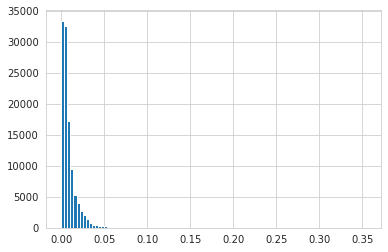

In [12]:
data.test.loc[vt, 'confidence'].hist(bins=100)

In [13]:
# # val set
# mid_value = math.floor(model_config['output_size'] / 2)
#
# vl = (data.val.is_val == True)
#
# data.val.loc[vl, 'close_true'] = y_true_np_val[:, 0].flatten()
# data.val.loc[vl, 'close_pred'] = y_hat_np_val[:, 0, mid_value].flatten()
#
# data.val.loc[vl, 'close_true_unscaled'] = y_true_val_unscaled[:, 0].flatten()
# data.val.loc[vl, 'close_pred_unscaled'] = y_val_hat_unscaled[:, 0, mid_value].flatten()
#
# data.val.loc[vl, 'target_true'] = (y_true_np_val[:, 1] - y_true_np_val[:, 0]) / y_true_np_val[:, 0]
# data.val.loc[vl, 'target_pred'] = (y_hat_np_val[:, 1, mid_value] - y_hat_np_val[:, 0, mid_value]) / y_hat_np_val[:, 0, mid_value]
#
# for i in range(model_config['output_size']):
#     data.val.loc[vl, f'close_pred_unscaled_full_{i}'] = pd.Series(list(y_val_hat_unscaled[:, :, i]), index=data.val[vl].index)
#
# data.val.loc[vl, 'target_true_unscaled'] = (y_true_val_unscaled[:, 1] - y_true_val_unscaled[:, 0]) / y_true_val_unscaled[:, 0]
# data.val.loc[vl, 'target_pred_unscaled'] = (y_val_hat_unscaled[:, 1, mid_value] - y_val_hat_unscaled[:, 0, mid_value]) / y_val_hat_unscaled[:, 0, mid_value]
#
# data.val.loc[vl, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']].head(2)

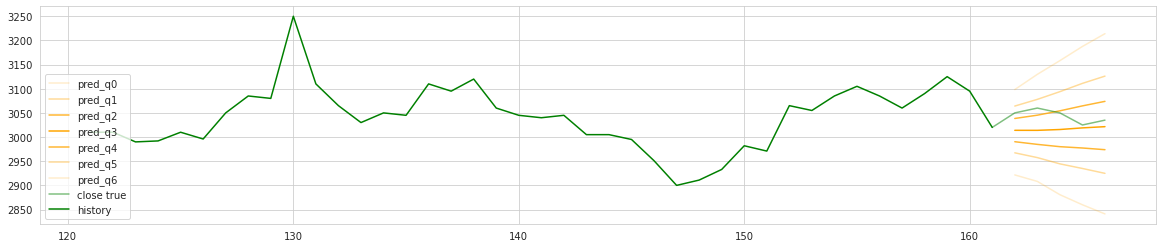

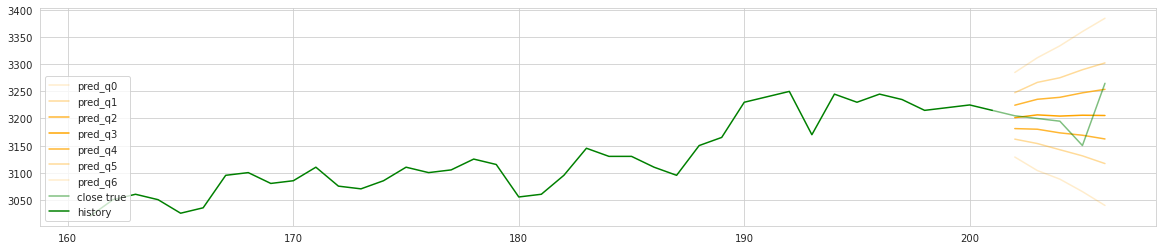

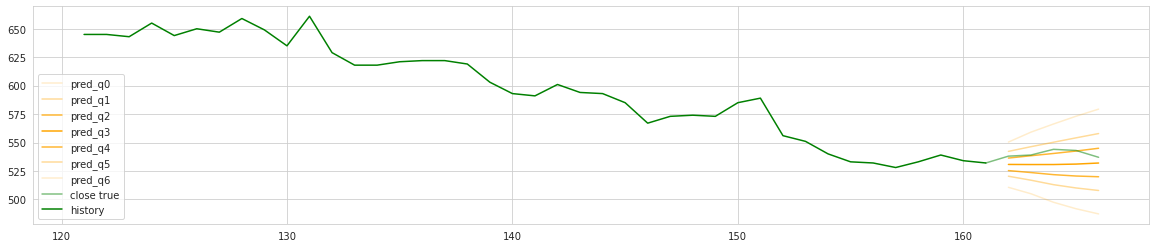

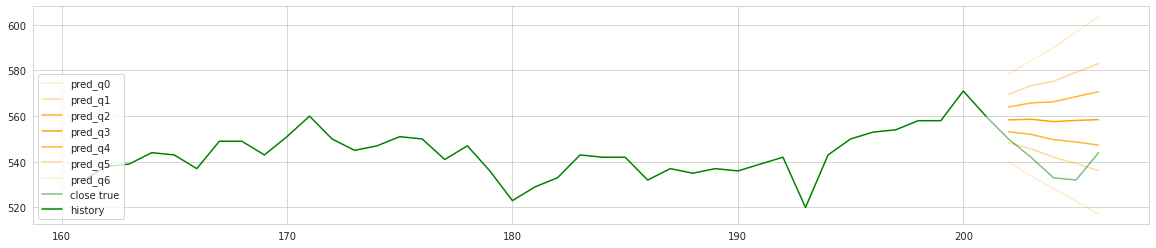

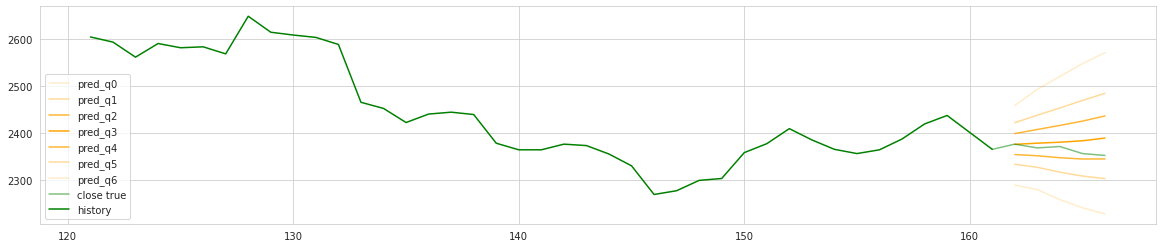

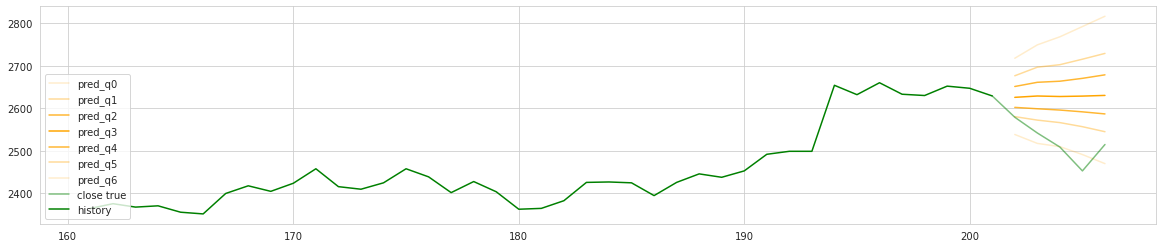

In [14]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

for sc in data.test.SecuritiesCode.unique()[:3]:
    for start_point in [10, 50]:
        df_full = data.test[(data.test.SecuritiesCode == sc)]
        df_pred = data.test[(data.test.SecuritiesCode == sc) & vt]

        df_pred = df_pred[(df_pred.Timestamp_1 >= df_pred.Timestamp_1.min() + start_point) &
                          (df_pred.Timestamp_1 <= df_pred.Timestamp_1.min() + start_point + max_prediction_length)]
        df_full = df_full[(df_full.Timestamp_1 >= df_pred.Timestamp_1.min() - (max_encoder_length - 110))
                          & (df_full.Timestamp_1 <= df_pred.Timestamp_1.min())]

        figure = plt.figure(figsize=(20, 4))

        for i, a in zip(range(model_config['output_size']), [0.2, .4, .8, 1, .8, .4, .2]):
            plt.plot(df_pred.Timestamp_1.iloc[1:], df_pred[f'close_pred_unscaled_full_{i}'].iloc[0], label=f'pred_q{i}', figure=figure, c='orange', alpha=a)

        plt.plot(df_pred.Timestamp_1, df_pred.Close, label='close true', figure=figure, alpha=.5, c='g')
        # plt.plot(df_pred.Date + datetime.timedelta(days=1), df_pred.close_pred_unscaled, label='close_pred_unscaled', figure=figure, alpha=.5)

        # Plot history
        plt.plot(df_full.Timestamp_1, df_full.Close, label='history', figure=figure, c='g')

        plt.legend(loc='lower left')
        plt.show()

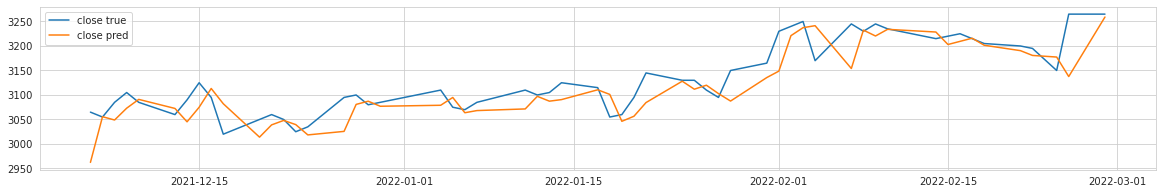

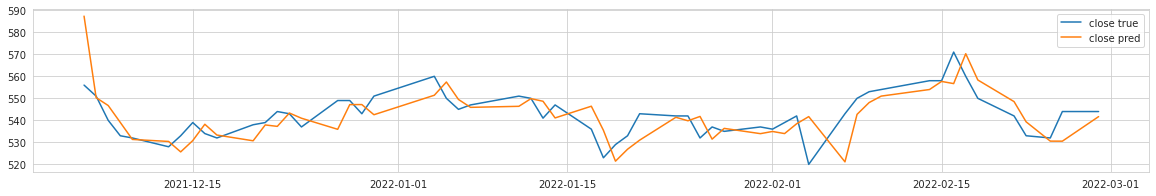

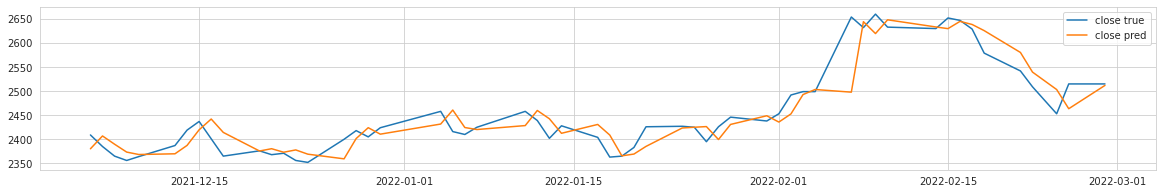

In [15]:
import matplotlib.pyplot as plt

for sc in data.test.SecuritiesCode.unique()[:3]:
    df_pred = data.test[(data.test.SecuritiesCode == sc) & vt]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df_pred.Date, df_pred.close_true_unscaled, label='close true', figure=figure)
    plt.plot(df_pred.Date, df_pred.close_pred_unscaled, label='close pred', figure=figure)

    plt.legend()
    plt.show()

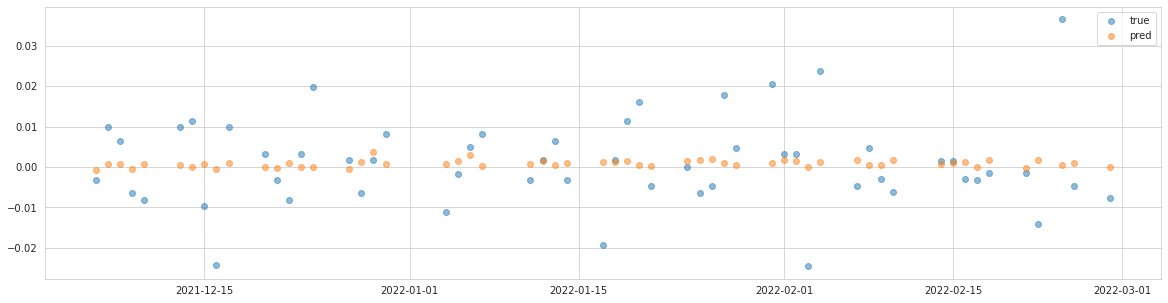

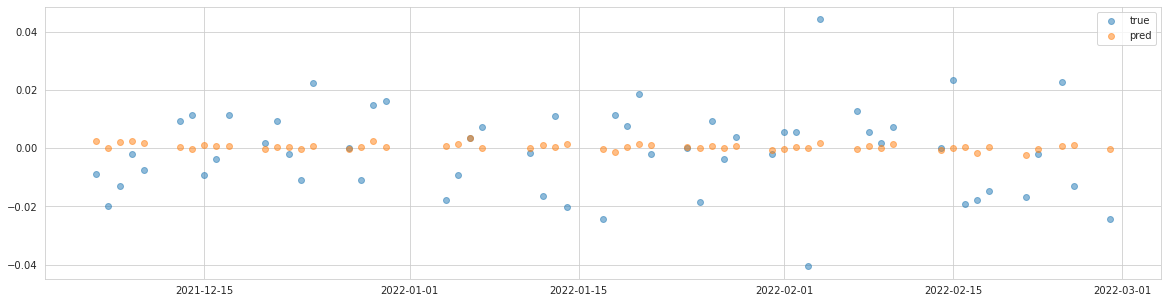

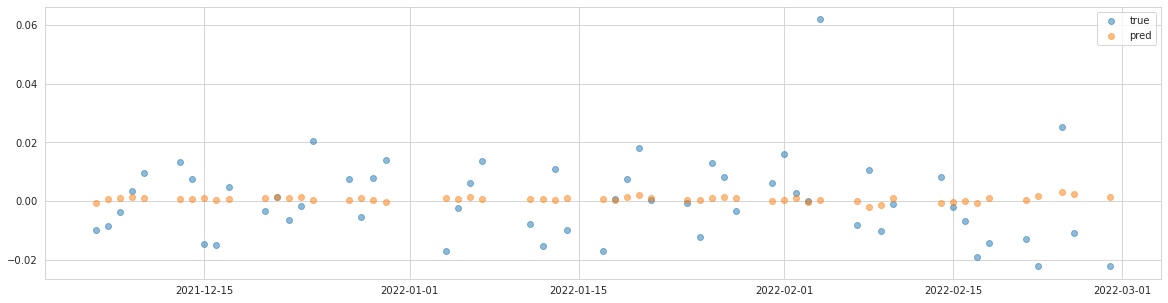

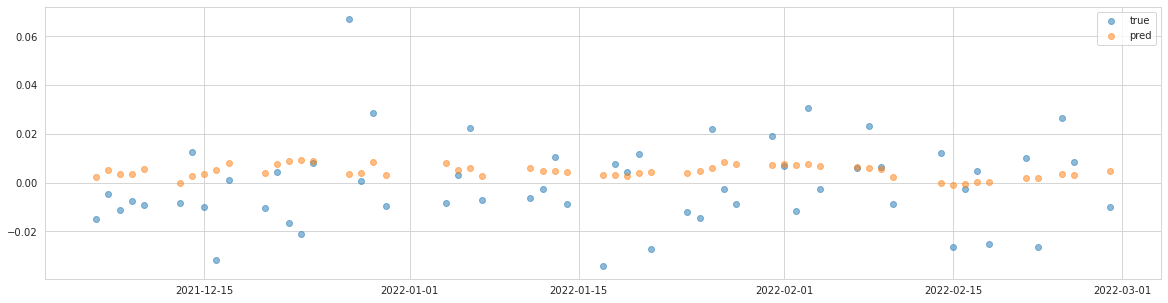

In [16]:
import matplotlib.pyplot as plt

recreated_target_is_valid = data.test.groupby('SecuritiesCode').apply(lambda x: (x.authentic == True).shift(-2).fillna(value=False) & (x.authentic == True).shift(-1).fillna(value=False) & (x.authentic == True)).reset_index(drop=True)
evaluated_target = (data.test.authentic == True) & vt

for sc in data.test.SecuritiesCode.unique()[:4]:
    df_pred = data.test[(data.test.SecuritiesCode == sc) & evaluated_target]
    figure = plt.figure(figsize=(20, 5))
    plt.scatter(df_pred.Date, df_pred.Target, label='true', figure=figure, alpha=.5)
    # plt.scatter(df.Date, df.target_true_unscaled, label='true2', figure=figure, alpha=.5)
    plt.scatter(df_pred.Date, df_pred.target_pred_unscaled, label='pred', figure=figure, alpha=.5)
    plt.legend()
    plt.show()

### Eval

In [17]:
from utilities.evaluation import calc_spread_return_sharpe

def eval(df, test=False):
    d = {
        'sharpe': calc_spread_return_sharpe(df),
        'money_gained': df.loc[df.Rank < 200].Target.sum() - df.loc[df.Rank >= 1800].Target.sum(),
        'true_positive': ((df.loc[df.Rank < 200].Target > 0).sum(), (df.loc[df.Rank >= 1800].Target <= 0).sum()),
        'false_positive': ((df.loc[df.Rank < 200].Target <= 0).sum(), (df.loc[df.Rank >= 1800].Target > 0).sum()),
        'true_positive_sum': (df.loc[df.Rank < 200].Target > 0).sum() + (df.loc[df.Rank >= 1800].Target <= 0).sum(),
        'false_positive_sum': (df.loc[df.Rank < 200].Target <= 0).sum() + (df.loc[df.Rank >= 1800].Target > 0).sum(),
    }
    if not test:
        d['overall accuracy on target binary classification'] = ((df.Target >= 0) == (df.target_pred_unscaled >= 0)).mean()

    return d

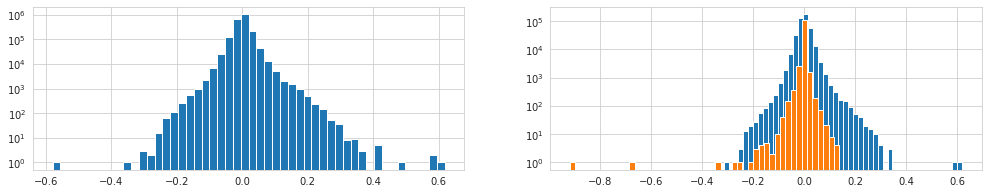

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(17, 3))

data.train.Target.hist(ax=axs[0], label='true distribution train', bins=50, log=True)
data.test.Target.hist(ax=axs[1], label='true distribution test', bins=50, log=True)
data.test.target_pred_unscaled.hist(ax=axs[1], label='pred distribution test', bins=50, log=True)
plt.show()

In [19]:
(data.test.Target > 0).mean(), (data.test.target_pred_unscaled > 0).mean()

(0.46179620853080566, 0.15295971563981042)

### Test set

In [20]:
data.test.loc[vt, 'Rank'] = (data.test.loc[vt].groupby("Date")["Target"].rank(ascending=False, method="first") - 1).astype(int)
eval(data.test.loc[vt], test=True)

{'sharpe': 5.434704919895069,
 'money_gained': 787.8921722685847,
 'true_positive': (10878, 11167),
 'false_positive': (322, 33),
 'true_positive_sum': 22045,
 'false_positive_sum': 355}

In [21]:
data.test.loc[vt, 'Rank'] = (data.test.loc[vt].groupby("Date")["target_pred_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
eval(data.test.loc[vt])

{'sharpe': 0.09967041325361596,
 'money_gained': 8.261993989320615,
 'true_positive': (5116, 6096),
 'false_positive': (6084, 5104),
 'true_positive_sum': 11212,
 'false_positive_sum': 11188,
 'overall accuracy on target binary classification': 0.5043839285714286}

#### Add confidence interval to distribution

In [22]:
data.test.loc[vt, 'target_pred_unscaled_weighted'] = data.test[vt].target_pred_unscaled + (data.test[vt].target_pred_unscaled * (data.test[vt].confidence * 105))

data.test.loc[vt, 'Rank'] = (data.test.loc[vt].groupby("Date")["target_pred_unscaled_weighted"].rank(ascending=False, method="first") - 1).astype(int)
eval(data.test.loc[vt])

{'sharpe': 0.1316651432021343,
 'money_gained': 10.04576232343257,
 'true_positive': (5107, 6116),
 'false_positive': (6093, 5084),
 'true_positive_sum': 11223,
 'false_positive_sum': 11177,
 'overall accuracy on target binary classification': 0.5043839285714286}

#### Interpretation

torch.Size([64, 150, 31])


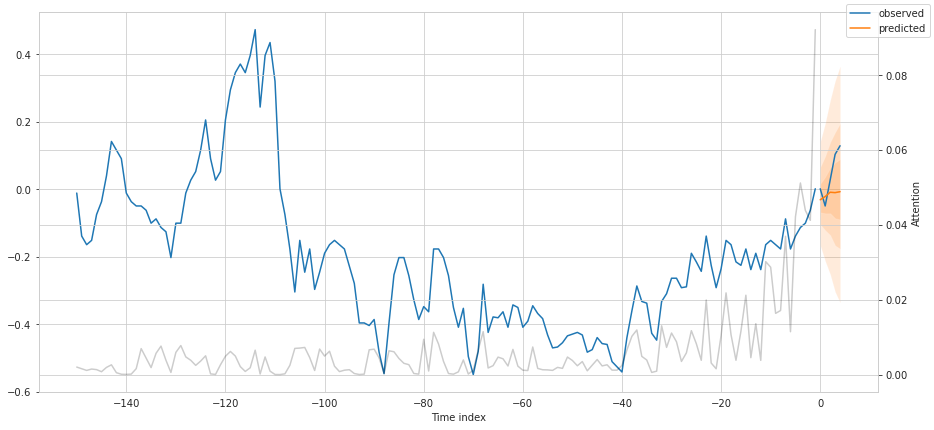

In [23]:
for X, (y, _) in val_dl:
    out = model.forward(X)
    print(X['encoder_cont'].shape)
    fig, ax = plt.subplots(1, 1, figsize=(13, 6))
    interpretation = model.interpret_output(out, reduction='sum')
    # model.plot_interpretation(interpretation)
    model.plot_prediction(X, out, idx=1, ax=ax)
    break

In [36]:

test_dl = data_ts.test.to_dataloader(
    batch_size=200,  # Test on a larger batch
    num_workers=12,
    shuffle=False
)

In [64]:
interpretation_mean = None


for i, (X, (y, _)) in tqdm(enumerate(test_dl)):
    out = model.forward(X)
    interpretation = model.interpret_output(out, reduction='sum')
    # interpretation_mean = interpretation if interpretation_mean is None else
    # fig, ax = plt.subplots(1, 1, figsize=(13, 6))
    # model.plot_interpretation(interpretation)
    # model.plot_prediction(X, out, idx=20, ax=ax)
    if interpretation_mean is None:
        interpretation_mean = {item:(interpretation[item].cpu().detach().numpy().reshape(1, *interpretation[item].shape)) for item in interpretation}
    else:
        interpretation_mean = {item:np.concatenate((interpretation[item].cpu().detach().numpy().reshape(1, *interpretation[item].shape), interpretation_mean[item])) for item in interpretation_mean}
    # if i == 50:
    #     break



0it [00:00, ?it/s]

In [62]:
interpretation_mean["attention"].shape

(150,)

In [65]:
interpretation_mean = {item:np.mean(interpretation_mean[item], axis=0) for item in interpretation_mean}

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x738 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

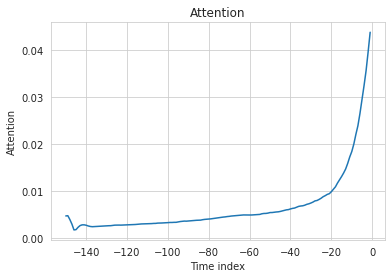

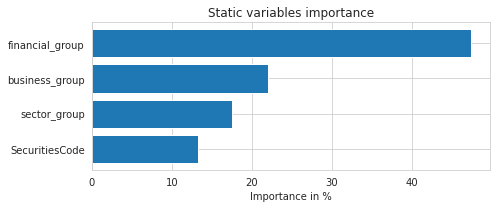

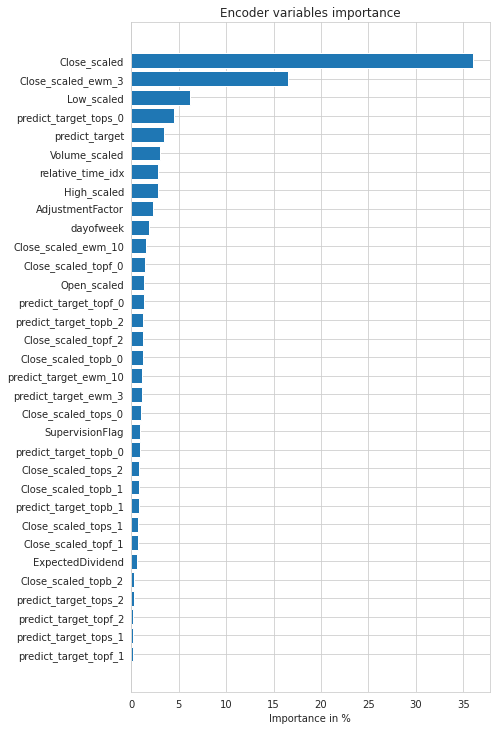

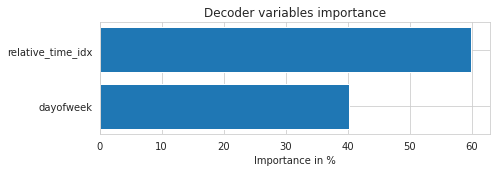

In [67]:
model.plot_interpretation({item:torch.tensor(interpretation_mean[item]) for item in interpretation_mean})


{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x738 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

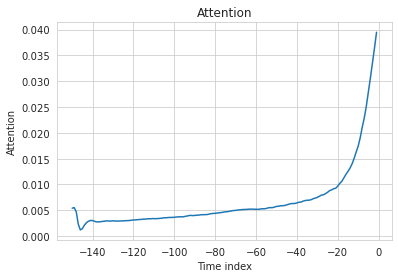

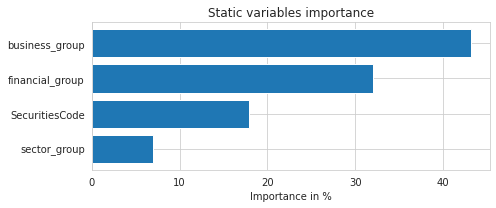

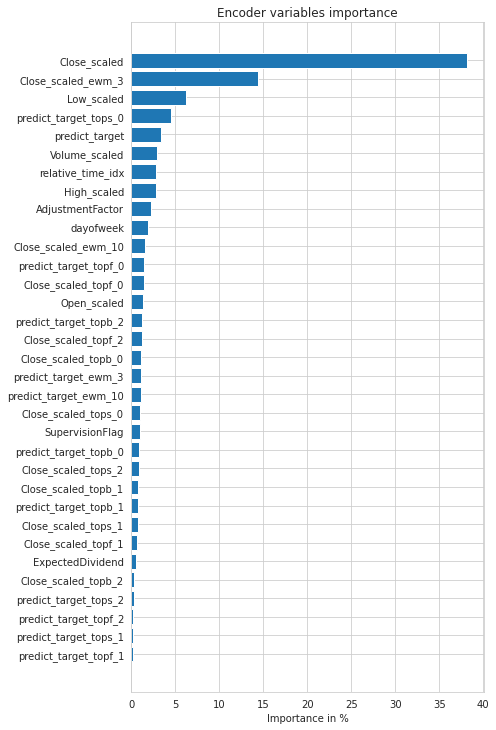

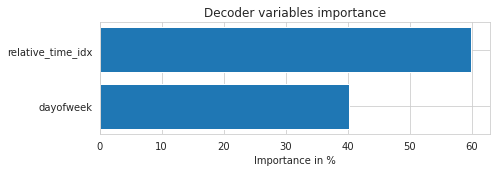

In [63]:
model.plot_interpretation({item:torch.tensor(interpretation_mean[item]) for item in interpretation_mean})


In [30]:
interpretation

{'attention': tensor([ 0.3137,  0.2586,  0.1885,  0.1716,  0.1107,  0.1106,  0.2379,  0.3678,
          0.4333,  0.4911,  0.5309,  0.5749,  0.5824,  0.5887,  0.5933,  0.5871,
          0.5674,  0.5577,  0.5518,  0.5573,  0.5862,  0.5880,  0.5956,  0.6009,
          0.5890,  0.5726,  0.5468,  0.5452,  0.5788,  0.5845,  0.5829,  0.5875,
          0.5858,  0.5829,  0.6197,  0.6229,  0.6190,  0.6278,  0.6388,  0.6592,
          0.6583,  0.6338,  0.6227,  0.6236,  0.6327,  0.6424,  0.6468,  0.6479,
          0.6652,  0.7191,  0.7676,  0.7834,  0.7776,  0.8210,  0.8149,  0.8204,
          0.8468,  0.8682,  0.9401,  0.9526,  0.9703,  0.9670,  0.9671,  0.9881,
          0.9773,  0.9877,  0.9608,  0.9664,  0.9780,  1.0015,  1.0310,  1.0432,
          1.0596,  1.0649,  1.1031,  1.1075,  1.0996,  1.1051,  1.0955,  1.1250,
          1.1061,  1.0863,  1.0637,  1.0671,  1.0656,  1.0469,  1.0417,  1.0452,
          1.0432,  1.0407,  0.9748,  0.9745,  0.9643,  0.9629,  0.9363,  0.8935,
          0.914

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x738 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

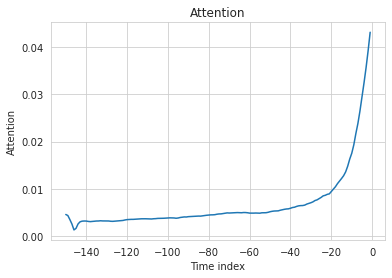

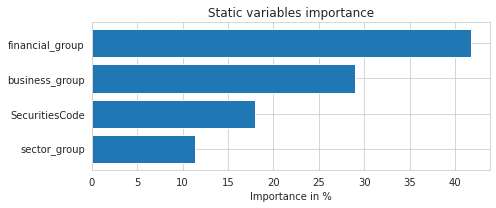

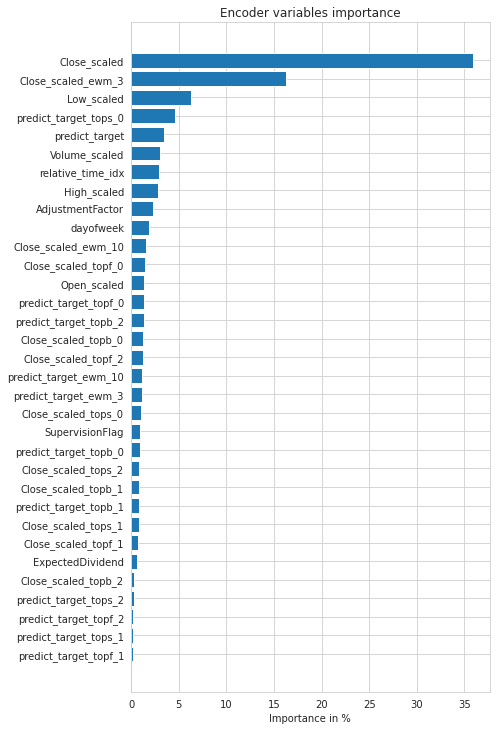

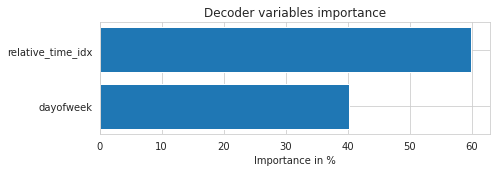

In [25]:
model.plot_interpretation(interpretation)